In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

2024-06-02 18:49:56.170909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset = 'keypoint.csv'
model_path = 'bud_classifier.hdf5'
tf_path = 'bud_classifier.tflite'

NUM_OF_GESTURE_BUD = 8

In [3]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21*2)+1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, random_state=42)

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_OF_GESTURE_BUD, activation='softmax')
])

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_6 (Dropout)         (None, 42)                0         
                                                                 
 dense_9 (Dense)             (None, 20)                860       
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 8)                 88        
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [34]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_path, verbose=1, save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, verbose=1
)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test,y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
33/46 [====================>.........] - ETA: 0s - loss: 2.1235 - accuracy: 0.1335
Epoch 1: saving model to model/bud_classifier/bud_classifier.hdf5
46/46 [==============================] - 1s 8ms/step - loss: 2.0985 - accuracy: 0.1480 - val_loss: 1.9787 - val_accuracy: 0.3837
Epoch 2/1000
39/46 [========================>.....] - ETA: 0s - loss: 1.9513 - accuracy: 0.2606

/Users/yychan/anaconda3/envs/mediapipe/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: saving model to model/bud_classifier/bud_classifier.hdf5
46/46 [==============================] - 0s 5ms/step - loss: 1.9378 - accuracy: 0.2657 - val_loss: 1.8143 - val_accuracy: 0.3904
Epoch 3/1000
43/46 [===========================>..] - ETA: 0s - loss: 1.7856 - accuracy: 0.3425
Epoch 3: saving model to model/bud_classifier/bud_classifier.hdf5
46/46 [==============================] - 0s 6ms/step - loss: 1.7855 - accuracy: 0.3422 - val_loss: 1.6275 - val_accuracy: 0.5154
Epoch 4/1000
43/46 [===========================>..] - ETA: 0s - loss: 1.6240 - accuracy: 0.4132
Epoch 4: saving model to model/bud_classifier/bud_classifier.hdf5
46/46 [==============================] - 0s 6ms/step - loss: 1.6182 - accuracy: 0.4150 - val_loss: 1.4328 - val_accuracy: 0.5888
Epoch 5/1000
45/46 [============================>.] - ETA: 0s - loss: 1.4678 - accuracy: 0.4406
Epoch 5: saving model to model/bud_classifier/bud_classifier.hdf5
46/46 [==============================] - 0s 4ms/step - loss:

In [36]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

16/16 [==============================] - 0s 1ms/step - loss: 0.1542 - accuracy: 0.9636


In [37]:
model = tf.keras.models.load_model(model_path)

In [38]:
predict_result = model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 149ms/step
[9.9655089e-04 4.7781818e-08 7.0511544e-01 6.1005943e-07 2.4530641e-04
 1.8464204e-15 6.2237433e-03 2.8741834e-01]
2


61/61 [==============================] - 0s 1ms/step


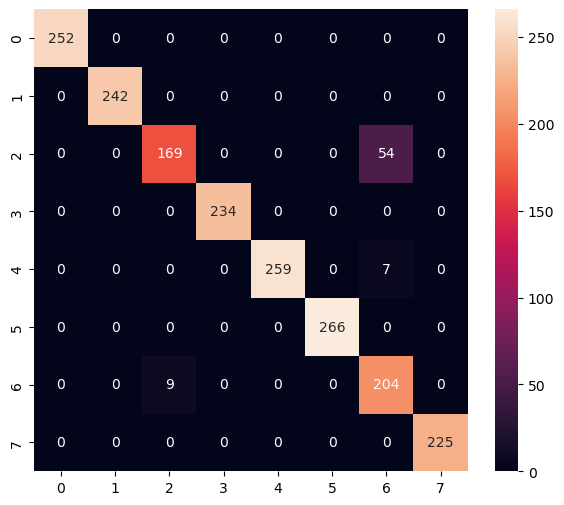

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       252
           1       1.00      1.00      1.00       242
           2       0.95      0.76      0.84       223
           3       1.00      1.00      1.00       234
           4       1.00      0.97      0.99       266
           5       1.00      1.00      1.00       266
           6       0.77      0.96      0.85       213
           7       1.00      1.00      1.00       225

    accuracy                           0.96      1921
   macro avg       0.96      0.96      0.96      1921
weighted avg       0.97      0.96      0.96      1921



In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_test, y_pred):
    labels = sorted(list(set(y_test)))
    cmx_data = confusion_matrix(y_test, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_test)), 0)
    plt.show()

    print('Classification Report')
    print(classification_report(y_test, y_pred))

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)

In [40]:
model.save(model_path, include_optimizer=False)

/Users/yychan/anaconda3/envs/mediapipe/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tf_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpqeibag_e/assets


INFO:tensorflow:Assets written to: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpqeibag_e/assets
2024-05-31 15:33:44.529919: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-05-31 15:33:44.529952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-05-31 15:33:44.530294: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpqeibag_e
2024-05-31 15:33:44.532502: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-05-31 15:33:44.532519: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/ll/j569tccx08d3syg9l4jjg7v40000gn/T/tmpqeibag_e
2024-05-31 15:33:44.539024: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-05-31 15:33:44.599051: I tensorflow/cc/saved_model/loader.cc:215] Running initialization

6772

In [42]:
interpreter = tf.lite.Interpreter(model_path=tf_path)
interpreter.allocate_tensors()

In [43]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array([x_test[0]]))

%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

UsageError: Line magic function `%%time` not found.
